In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.9.1
sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.3
sklearn 1.1.1
tensorflow 2.9.1
keras.api._v2.keras 2.9.0


In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.2))  # rate是丢弃的比例
# AlphaDropout相对于普通Dropout优势: 1.均值和方差不变 2.归一化性质也不变
# model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [6]:
tf.random.set_seed(0)
layer = tf.keras.layers.Dropout(0.5, input_shape=(2,))
layer = tf.keras.layers.AlphaDropout(0.5, input_shape=(2,))
data = np.arange(1,13).reshape(6, 2).astype(np.float32)
print(data)

[[ 1.  2.]
 [ 3.  4.]
 [ 5.  6.]
 [ 7.  8.]
 [ 9. 10.]
 [11. 12.]]


In [8]:
outputs = layer(data, training=True)
print(outputs)

tf.Tensor(
[[ 1.6655989 -0.7791938]
 [ 3.4384084  4.3248134]
 [ 5.2112184  6.097623 ]
 [-0.7791938  7.870433 ]
 [-0.7791938 -0.7791938]
 [10.529648  11.416052 ]], shape=(6, 2), dtype=float32)


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               1

In [11]:
len(model.layers)

23

In [12]:
model.variables

[<tf.Variable 'dense/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[-0.05021978,  0.03957347, -0.00200991, ..., -0.07454404,
          0.03445059, -0.03821786],
        [ 0.01052265,  0.05010289, -0.02878251, ..., -0.07921793,
          0.03162571,  0.03126749],
        [-0.0668906 , -0.02846495,  0.00556383, ..., -0.04611138,
         -0.04635298,  0.05323511],
        ...,
        [ 0.0430166 , -0.04540234,  0.01669615, ..., -0.00289799,
         -0.06238638,  0.05290347],
        [-0.04960681,  0.02898443,  0.0177997 , ..., -0.00799028,
          0.0621921 , -0.00543112],
        [ 0.01316525,  0.05437016, -0.00485186, ...,  0.01891418,
          0.0418357 ,  0.04250421]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(100,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [13]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-selu-dropout-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/100


2022-07-21 23:28:00.120987: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 [==============================] - 7s 4ms/step - loss: 0.8940 - accuracy: 0.6959 - val_loss: 0.5516 - val_accuracy: 0.8180
Epoch 2/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5821 - accuracy: 0.8009 - val_loss: 0.4975 - val_accuracy: 0.8352
Epoch 3/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4990 - accuracy: 0.8269 - val_loss: 0.4848 - val_accuracy: 0.8458
Epoch 4/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4522 - accuracy: 0.8418 - val_loss: 0.5050 - val_accuracy: 0.8392
Epoch 5/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4214 - accuracy: 0.8514 - val_loss: 0.4346 - val_accuracy: 0.8590
Epoch 6/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3967 - accuracy: 0.8584 - val_loss: 0.4143 - val_accuracy: 0.8676
Epoch 7/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3795 - accuracy: 0.8655 - val_loss: 0.4091 - val_accuracy: 0.86

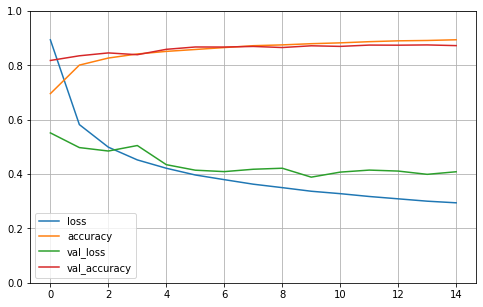

In [14]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [15]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.4494214951992035, 0.8626999855041504]